# Inference on Resolution $256^2$ px

In [1]:
%cd ../..

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import nn, Tensor, optim
import torchvision.transforms as T
from torchvision.transforms.functional import to_pil_image, to_tensor
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image

from dlbpgm.models import LGU, LGT, LGR

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

/home/jovyan/work/Masterarbeit


device(type='cuda', index=1)

## Load Example

In [20]:
def imshow(images, nrow):
    grid_img = make_grid(images, nrow=nrow)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")

In [9]:
example_dir = Path("dlbpgm/resources/example_images/")

The `example_dir` contains 4 input and 5 target images, as well as the corresponding timestamps, which are already saved as tensors.

We now load all files for this example and prepare them so that they can be processed by the models.
The images are prepared to fit in the format [B, N, 3, 256, 256], where B corresponds to the batch size and N to the number of images.
The corresponding timestamps will have the format [B, N].

In [49]:
x_in  = [Image.open(example_dir/f"x_in_{i}.png") for i in range(4)]
x_out = [Image.open(example_dir/f"x_out_{i}.png") for i in range(5)]
x_in  = torch.stack([to_tensor(img) for img in x_in])
x_out = torch.stack([to_tensor(img) for img in x_out])

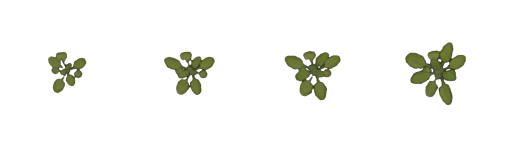

In [50]:
imshow(x_in, nrow=4)

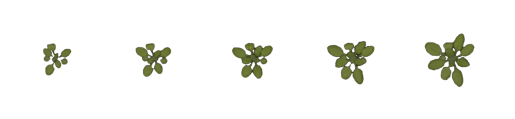

In [51]:
imshow(x_out, nrow=5)

In [52]:
print("x_in:", x_in.shape)
print("x_out:", x_out.shape)

x_in: torch.Size([4, 4, 512, 512])
x_out: torch.Size([5, 4, 512, 512])


As we can see, the images are still in RGBA format in a size of $512^2$ px.
In the next step, we will convert these to RGB images by multiplying the alpha channel with the other three color channels.
We will then downscale them to $256^2$ px.

In [53]:
resize = T.Resize((256, 256), antialias=True)

In [54]:
x_in  = resize(x_in[:, :3] * x_in[:, 3:]).unsqueeze(0)
x_out = resize(x_out[:, :3] * x_out[:, 3:]).unsqueeze(0)

In [55]:
t_in = torch.load(example_dir/"t_in.pt").unsqueeze(0)
t_out = torch.load(example_dir/"t_out.pt").unsqueeze(0)

In [56]:
print("x_in:", x_in.shape)
print("x_out:", x_out.shape)
print("t_in:", t_in.shape)
print("t_out:", t_out.shape)

x_in: torch.Size([1, 4, 3, 256, 256])
x_out: torch.Size([1, 5, 3, 256, 256])
t_in: torch.Size([1, 4])
t_out: torch.Size([1, 5])


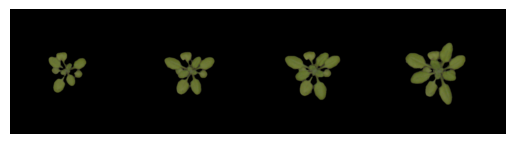

In [59]:
imshow(x_in[0], nrow=4)

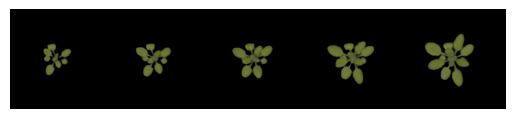

In [60]:
imshow(x_out[0], nrow=5)

## Load Model
The preconfigured and pretrained models can be loaded via the wrapper classes `LGR`, `LGT`, and `LGU` by simply passing the image resolution and the path to the corresponding checkpoint.

The wrapper classes contain the pre-trained VAE and the corresponding LGM for growth modeling in latent space.
With the wrapper classes, we can perform the inference end-to-end in the pixel space.

In [ ]:
lgu = LGU(resolution=256, ckpt_path="Arabidopsis/experiments/256x256/LGUnet/lgu256.pt")
lgt = LGT(resolution=256, ckpt_path="Arabidopsis/experiments/256x256/LGT/lgt256.pt")

In [61]:
with torch.no_grad():
    x_lgu = lgu(x_in, t_in, t_out)
    x_lgt = lgt(x_in, t_in, t_out)

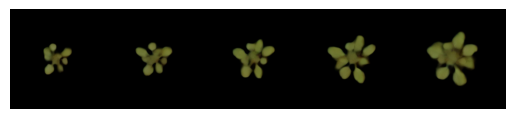

In [62]:
imshow(x_lgu.flatten(0, 1), nrow=5)

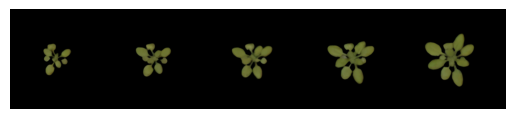

In [63]:
imshow(x_lgt.flatten(0, 1), nrow=5)